# This Notebook illustrates how to use the Sidre/Conduit Loader

## Installing conduit with Kosh

```bash
git clone https://github.com/LLNL/conduit.git
cd conduit
mkdir build
cd build
export MY_PYTHON=$(python -c "import sys;print(sys.prefix)")
cmake ../src -DCMAKE_INSTALL_PREFIX=${MY_PYTHON} -DENABLE_PYTHON=ON -DHDF5_DIR=/usr
make -j
make install
```

## Making sure conduit is in your path

in your python scripts add

```python
import sys
import os
sys.path.append(os.path.join(sys.prefix,"python-modules"))
```

Let's import the necessary modules for this notebook

In [1]:
from __future__ import print_function
import sys
import os
sys.path.append(os.path.join(sys.prefix,"python-modules"))
import kosh

In [2]:
# Let's import data if not already present
import requests
import os

source_uri = "https://github.com/LLNL/conduit/raw/master/src/tests/relay/data/"
files = ['out_spio_blueprint_example.root',]
files +=  [os.path.join('out_spio_blueprint_example', 'out_spio_blueprint_example_000000{}.hdf5'.format(x)) for x in range(4)]

for filename in files:
    if not os.path.exists(filename):
        print("Fetching",filename)
        if not os.path.exists(os.path.dirname(os.path.abspath(filename))):
            os.makedirs(os.path.dirname(os.path.abspath(filename)))
        r = requests.get(source_uri+filename, stream=True)
        with open(filename,"wb") as f:
            for chunk in r.iter_content(chunk_size=1024):
                if chunk:
                    f.write(chunk) # write this chunk to a local version of the file
    else:
        print("You already have {}".format(filename))

You already have out_spio_blueprint_example.root
You already have out_spio_blueprint_example/out_spio_blueprint_example_0000000.hdf5
You already have out_spio_blueprint_example/out_spio_blueprint_example_0000001.hdf5
You already have out_spio_blueprint_example/out_spio_blueprint_example_0000002.hdf5
You already have out_spio_blueprint_example/out_spio_blueprint_example_0000003.hdf5


Let's create a new store and create a dataset pointing to these example files

In [3]:
# Create a new store
kosh_example_sql_file = "my_store.sql"
    
# Create db on file
store = kosh.create_new_db(kosh_example_sql_file)

dataset = store.create(name="example", metadata={'project':"example"})
    
 #Associate file with datasets
dataset.associate(files[0], mime_type="sidre_mesh_blueprint_fields")

'c46f79cc2fc54c89980a742ad0592691'

Let's list the features available to us

In [4]:
dataset.list_features()

['mesh/field', 'mesh/rank']

Let's retrieve the *field* as a numpy array (default)

In [5]:
dataset.get("mesh/field")

array([0., 1., 2., 3., 0., 1., 2., 3., 0., 1., 2., 3., 0., 1., 2., 3.])

We can also retrieve it as a plain sider/path object

In [6]:
dataset.get("mesh/field", format="sidre/path")

[<IOHandle at 0x2aaae00f5378>, 'root/blueprint_index/mesh/fields/field/path']

We also have a transformer built on top of the sidre loader that can return basic statistics.

In [7]:
stats = dataset.get("mesh/field", transformers=[kosh.transformers.SidreFeatureMetrics()])
print("Statistics:", stats.keys())

Statistics: dict_keys(['histogram', 'min', 'max', 'mean', 'std'])


(array([45.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  4.]),
 array([0. , 0.4, 0.8, 1.2, 1.6, 2. , 2.4, 2.8, 3.2, 3.6, 4. ]),
 <a list of 10 Patch objects>)

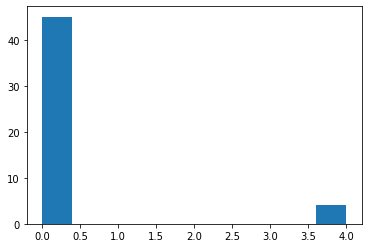

In [8]:
import matplotlib.pyplot as plt
plt.hist(stats["histogram"])